In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import math
import struct

import xarray

%matplotlib inline
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "animation.html" : 'html5'}
plt.rcParams.update(params)

In [3]:

def hillshade(data,scale=10.0,azdeg=165.0,altdeg=45.0):
    ''' convert data to hillshade based on matplotlib.colors.LightSource class.
        input: 
             data - a 2-d array of data
             scale - scaling value of the data. higher number = lower gradient 
             azdeg - where the light comes from: 0 south ; 90 east ; 180 north ;
                          270 west
             altdeg - where the light comes from: 0 horison ; 90 zenith
        output: a 2-d array of normalized hilshade 
    '''
    # convert alt, az to radians
    az = azdeg*math.pi/180.0
    alt = altdeg*math.pi/180.0
    # gradient in x and y directions
    dy, dx = np.gradient(data[-1::-1]/float(scale))
    slope = 0.5*math.pi - np.arctan(np.hypot(dx, dy))
    aspect = np.arctan2(dy, dx)
    intensity = np.sin(alt)*np.sin(slope) + np.cos(alt)*np.cos(slope)*np.cos(-az - aspect - 0.5*math.pi)
    return intensity[-1::-1]

In [74]:
def load(var, num):
    folder = "../build/x64-Release/benchmarks/results/mountain/"
    header_size = struct.calcsize("NN")
    with open(folder+var+"-"+str(num)+".bin", "rb") as file:
        header = file.read(header_size)
        result = np.frombuffer(file.read(), dtype = np.float64).astype(np.float64)
    
    nr, nc = struct.unpack("NN", header)
    
    return result.reshape(nr, nc)    

def pr(max_val):
    i = 32
    while i <= max_val:
        yield i
        i *= 2

bedrock = { num : load('bedrock', num) for num in pr(4096)}        

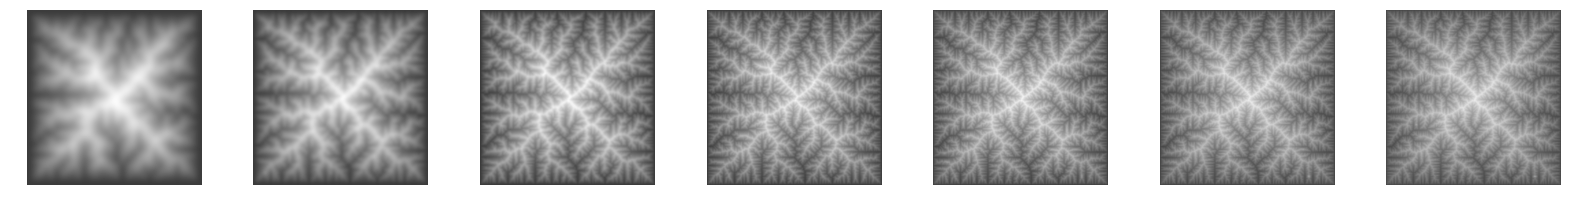

In [76]:
fig, axes = plt.subplots(ncols = len(bedrock)-1, figsize=(22,5))#, dpi = 150)

def rescale(data, vmin = None, vmax = None, clip = False):
    if vmin is None:
        vmin = np.min(data)
    if vmax is None:
        vmax = np.max(data)
        
    if clip:
        return np.clip((data - vmin) / (vmax - vmin), 0, 1)
    else:
        return (data - vmin) / (vmax - vmin)
            
def illum(dem):

    intensity = rescale(hillshade(dem, scale=100.0, azdeg=290.0,altdeg=45.0), vmin = 0.695, vmax = .715, clip = True)
    alt = rescale(rescale(dem), vmin = -.3, vmax = 1)
    return  alt# * intensity

def show(ax, data):
    axes[ax].imshow(illum(data), cmap =  plt.cm.gray, vmin = 0.0, vmax = 1.0, interpolation = 'bicubic')
    axes[ax].axis('off')


def ppr(max_val):
    i = 32
    k = 0
    while i <= max_val:
        yield k, i
        i *= 2
        k+= 1
        
for (k, i) in ppr(2048):
    show(k, bedrock[i])



fig.tight_layout()
#plt.savefig("jail.png")